# 5 整合深度学习框架

## 5.1 准备环境

In [26]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels


In [27]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [28]:
import IPython

def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.lexers import Python3Lexer
    from pygments.formatters import HtmlFormatter
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [29]:
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

## 5.2 通过Builder创建IRModule

### 5.2.1 Tensor Expression to build TensorIR
- tensor Expression 针对不同的尺寸去实现TensorIR

In [30]:
from tvm import te

In [31]:
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")
type(A)
A.shape

[128, 128]

**矩乘**

In [32]:
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")
C = te_matmul(A, B)
te.create_prim_func([A, B, C]).show()

# from tvm.script import tir as T
@T.prim_func
def func(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(128, 128), "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0, i1, i2 in T.grid(128, 128, 128):
        with T.block("matmul"):
            i, j, k = T.axis.remap("SSR", [i0, i1, i2])
            T.reads(A[i, k], B[k, j])
            T.writes(matmul[i, j])
            with T.init():
                matmul[i, j] = T.float32(0)
            matmul[i, j] = matmul[i, j] + A[i, k] * B[k, j]



**Relu**

In [33]:
def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")
    
X1 = te.placeholder((10,), name="X1", dtype="float32")
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()


# from tvm.script import tir as T
@T.prim_func
def func(X1: T.Buffer[10, "float32"], relu: T.Buffer[10, "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0 in T.serial(10):
        with T.block("relu"):
            i0_1 = T.axis.spatial(10, i0)
            T.reads(X1[i0_1])
            T.writes(relu[i0_1])
            relu[i0_1] = T.max(X1[i0_1], T.float32(0))



In [34]:
C = te_matmul(A, B)
D = te_relu(C)
te.create_prim_func([A, B, D]).show()

# from tvm.script import tir as T
@T.prim_func
def func(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], relu: T.Buffer[(128, 128), "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    matmul = T.alloc_buffer([128, 128], dtype="float32")
    for i0, i1, i2 in T.grid(128, 128, 128):
        with T.block("matmul"):
            i, j, k = T.axis.remap("SSR", [i0, i1, i2])
            T.reads(A[i, k], B[k, j])
            T.writes(matmul[i, j])
            with T.init():
                matmul[i, j] = T.float32(0)
            matmul[i, j] = matmul[i, j] + A[i, k] * B[k, j]
    for i0, i1 in T.grid(128, 128):
        with T.block("relu"):
            i0_1, i1_1 = T.axis.remap("SS", [i0, i1])
            T.reads(matmul[i0_1, i1_1])
            T.writes(relu[i0_1, i1_1])
            relu[i0_1, i1_1] = T.max(matmul[i0_1, i1_1], T.float32(0))



### 5.2.2 BlockBuilder to build IRModule
- 利用计算图连接多个TensorIR

In [35]:
A = relax.Var("A", (128, 128), relax.DynTensorType(2, "float32"))
B = relax.Var("B", (128, 128), relax.DynTensorType(2, "float32"))

In [36]:
bb = relax.BlockBuilder()

with bb.function("main"):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def te_matmul(rxplaceholder: T.Buffer[(128, 128), "float32"], rxplaceholder_1: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(128, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_matmul", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1, i2 in T.grid(128, 128, 128):
            with T.block("matmul"):
                i, j, k = T.axis.remap("SSR", [i0, i1, i2])
                T.reads(rxplaceholder[i, k], rxplaceholder_1[k, j])
                T.writes(matmul[i, j])
                with T.init():
                    matmul[i, j] = T.float32(0)
                matmul[i, j] = matmul[i, j] + rxplaceholder[i, k] * rxplaceholder_1[k, j]
    
    @T.prim_func
    def te_relu(rxplaceholder: T.Buffer[(128, 128), "float32"], relu: T.Buffer[(128, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_relu", 

### **5.2.3 BlockBuilder**

```
with bb.function("main"):
    with bb.dataflow():
```



In [38]:
type(C)
isinstance(C, relax.Var)

True

```
lv = R.call_tir(te_matmul, (A, B), (128, 128), dtype="float32")
C = bb.emit_te(te_matmul, A, B)
```
- 为 A 和 B 创建一个输入 te.placeholder，
- 通过 te_matmul 函数运行它们。
- 调用 te.create_prim_func 来创建一个 TensorIR 函数。
- 通过 call_tir 生成对函数的调用。

## 5.3 Pytorch导入模型

In [40]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

### 5.3.1 TorchFX GraphModule

In [41]:
model = MyModel()
fx_module = fx.symbolic_trace(model) # torch 里的计算图表示
type(fx_module)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

In [42]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7f1e52a6c940>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7f1e52a6c940>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


### 5.3.2 构造映射函数

- 创建一个 node_map，将 fx.Node 映射到相应的 relax.Var，该 relax.Var 代表 IRModule 中的已翻译节点。

- 以拓扑顺序迭代 FX 图中的节点。

- 给定映射输入，获取节点的映射输出。

In [43]:
def map_param(param: nn.Parameter):
    ndim = len(param.data.shape)
    return relax.const(
        param.data.cpu().numpy(), relax.DynTensorType(ndim, "float32")
    )

def fetch_attr(fx_mod, target: str):
    """Helper function to fetch an attr"""
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder":
                    # create input placeholder
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, shape, relax.DynTensorType(len(shape), "float32")
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        # output and finalize the function
        bb.emit_func_output(output, fn_inputs)
    return bb.get()

In [44]:
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = {
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def te_matmul(rxplaceholder: T.Buffer[(1, 128), "float32"], rxplaceholder_1: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_matmul", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1, i2 in T.grid(1, 128, 128):
            with T.block("matmul"):
                i, j, k = T.axis.remap("SSR", [i0, i1, i2])
                T.reads(rxplaceholder[i, k], rxplaceholder_1[k, j])
                T.writes(matmul[i, j])
                with T.init():
                    matmul[i, j] = T.float32(0)
                matmul[i, j] = matmul[i, j] + rxplaceholder[i, k] * rxplaceholder_1[k, j]
    
    @T.prim_func
    def te_relu(rxplaceholder: T.Buffer[(1, 128), "float32"], relu: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_relu", "tir.noali

## 5.4 FashionMNIST

In [ ]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

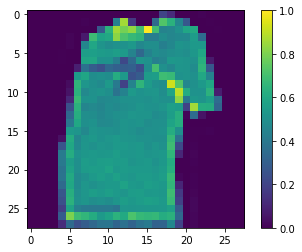

Class: T-shirt/top


In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [ ]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

In [49]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [50]:
import pickle as pkl

mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

In [51]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: T-shirt/top


In [55]:
from tvm import topi


def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)


MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },
)

MLPModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def add(rxplaceholder: T.Buffer[(1, 128), "float32"], rxplaceholder_1: T.Buffer[128, "float32"], T_add: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "add", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1 in T.grid(1, 128):
            with T.block("T_add"):
                ax0, ax1 = T.axis.remap("SS", [i0, i1])
                T.reads(rxplaceholder[ax0, ax1], rxplaceholder_1[ax1])
                T.writes(T_add[ax0, ax1])
                T_add[ax0, ax1] = rxplaceholder[ax0, ax1] + rxplaceholder_1[ax1]
    
    @T.prim_func
    def te_relu(rxplaceholder: T.Buffer[(1, 128), "float32"], relu: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_relu", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1 in T.grid(1, 128):
            with T.b

In [54]:
ex = relax.vm.build(MLPModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: T-shirt/top


## 5.5 翻译成高层算子

In [53]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit(relax.op.dense(x, w))
    return bb.emit(relax.op.add(y, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv: Tensor((1, 128), "float32") = relax.nn.dense(x, meta[relay.Constant][0])
            lv1: Tensor((1, 128), "float32") = relax.add(lv, meta[relay.Constant][1])
            lv2: Tensor((1, 128), "float32") = relax.nn.relu(lv1)
            lv3: Tensor((1, 10), "float32") = relax.nn.dense(lv2, meta[relay.Constant][2])
            lv4: Tensor((1, 10), "float32") = relax.add(lv3, meta[relay.Constant][3])
            gv: Tensor((1, 10), "float32") = lv4
            R.output(gv)
        return lv4
    

